# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [14]:
# Be sure to install the latest version of RLlib and sundry requirements
! pip install -U ray[rllib]
! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow

Requirement already up-to-date: ray[rllib] in /home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages (0.8.1)
  Using cached tensorflow-2.1.0-cp37-cp37m-manylinux2010_x86_64.whl (421.8 MB)
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
Processing /home/jhineman/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp37-none-any.whl
  Using cached tensorboard-2.1.0-py3-none-any.whl (3.8 MB)
Processing /home/jhineman/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833/opt_einsum-3.1.0-cp37-none-any.whl
  Using cached Keras_Preprocessing-1.1.0-py2.py3-none-any.whl (41 kB)
  Using cached google_pasta-0.1.8-py3-none-any.whl (57 kB)
Processing /home/jhineman/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp37-none-any.whl
Processing /home/jhineman/.cache/pip/wheels/cc/af/1a/498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e/absl_py-0.9.0-py3-none-any.whl
Processing /home/jhineman/.cache/pip/wheels/e5/78/69/f40ab7cae531c8f07003a9d1b4b81ebec14cda95519c57e7dd/wrapt-1.12.0-cp37-cp37m-linux_x86_64.whl
 

In [6]:
# view dependencies
! pip list | grep tensorflow

tensorflow             2.1.0              
tensorflow-estimator   2.1.0              


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [100]:
# Start ray locally (there are lots of configurations)
ray.init(num_cpus=4, ignore_reinit_error=True, log_to_driver=False)

2020-02-19 07:34:57,991	ERROR worker.py:688 -- Calling ray.init() again after it has already been called.


## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [3]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 5e-05,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_s

In [4]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-19 05:47:46,523	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-19 05:47:46,531	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-19 05:47:49,027	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [7]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-19_05-49-46
done: false
episode_len_mean: 21.43548387096774
episode_reward_max: 76.0
episode_reward_mean: 21.43548387096774
episode_reward_min: 9.0
episodes_this_iter: 186
episodes_total: 186
experiment_id: c5db5e6c6f5f4e5a9577433130e8cd52
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1444.419
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6621034145355225
      entropy_coeff: 0.0
      kl: 0.03152647987008095
      policy_loss: -0.042134784162044525
      total_loss: 148.3585968017578
      vf_explained_var: 0.038961268961429596
      vf_loss: 148.39442443847656
  load_time_ms: 48.515
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 2788.601
  update_time_ms: 403.083
iterations_since_restore: 1
node_ip: 192.168.1.170
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 9.753892215568863
  ram_util_percent: 53.06407185628743
pid: 19949
p

In [23]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [30]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [39]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[ 4.5951862e+00 -2.4160767e+38  2.9495916e-01  5.0103560e+37]


In [43]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [47]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-19 06:16:31,647	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [48]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-19_06-16-41
done: false
episode_len_mean: 21.688524590163933
episode_reward_max: 64.0
episode_reward_mean: 21.688524590163933
episode_reward_min: 9.0
episodes_this_iter: 183
episodes_total: 183
experiment_id: 56ddc8b53d0a4cc99a9162ca02685189
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1436.923
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6632076501846313
      entropy_coeff: 0.0
      kl: 0.029982194304466248
      policy_loss: -0.037228453904390335
      total_loss: 146.48733520507812
      vf_explained_var: 0.03170539438724518
      vf_loss: 146.51858520507812
  load_time_ms: 49.808
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 1118.474
  update_time_ms: 420.931
iterations_since_restore: 1
node_ip: 192.168.1.170
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 21.69285714285714
  ram_util_percent: 58.09999999999999
pid: 1994

custom_metrics: {}
date: 2020-02-19_06-16-54
done: false
episode_len_mean: 167.13
episode_reward_max: 200.0
episode_reward_mean: 167.13
episode_reward_min: 38.0
episodes_this_iter: 20
episodes_total: 412
experiment_id: 56ddc8b53d0a4cc99a9162ca02685189
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1212.04
  learner:
    default_policy:
      cur_kl_coeff: 0.15000000596046448
      cur_lr: 4.999999873689376e-05
      entropy: 0.5691795349121094
      entropy_coeff: 0.0
      kl: 0.0049133202992379665
      policy_loss: -0.004781582858413458
      total_loss: 551.9776000976562
      vf_explained_var: 0.07918348908424377
      vf_loss: 551.9816284179688
  load_time_ms: 8.095
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 1065.053
  update_time_ms: 62.58
iterations_since_restore: 7
node_ip: 192.168.1.170
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 43.375
  ram_util_percent: 57.8
pid: 19949
policy_reward_max: {}
policy_reward_mean: {}
pol

custom_metrics: {}
date: 2020-02-19_06-17-07
done: false
episode_len_mean: 195.61
episode_reward_max: 200.0
episode_reward_mean: 195.61
episode_reward_min: 141.0
episodes_this_iter: 20
episodes_total: 534
experiment_id: 56ddc8b53d0a4cc99a9162ca02685189
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1157.439
  learner:
    default_policy:
      cur_kl_coeff: 0.07500000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.48373815417289734
      entropy_coeff: 0.0
      kl: 0.005612557753920555
      policy_loss: -0.0031816435512155294
      total_loss: 348.22845458984375
      vf_explained_var: 0.44983890652656555
      vf_loss: 348.231201171875
  load_time_ms: 1.139
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 1023.266
  update_time_ms: 2.823
iterations_since_restore: 13
node_ip: 192.168.1.170
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 41.5
  ram_util_percent: 57.79999999999999
pid: 19949
policy_reward_max: {}
policy_rewa

custom_metrics: {}
date: 2020-02-19_06-17-21
done: false
episode_len_mean: 199.86
episode_reward_max: 200.0
episode_reward_mean: 199.86
episode_reward_min: 190.0
episodes_this_iter: 20
episodes_total: 654
experiment_id: 56ddc8b53d0a4cc99a9162ca02685189
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1162.005
  learner:
    default_policy:
      cur_kl_coeff: 0.01875000074505806
      cur_lr: 4.999999873689376e-05
      entropy: 0.4989548623561859
      entropy_coeff: 0.0
      kl: 0.0031236193608492613
      policy_loss: -0.0016235418152064085
      total_loss: 554.27783203125
      vf_explained_var: 0.2152165174484253
      vf_loss: 554.2794799804688
  load_time_ms: 1.14
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 1021.2
  update_time_ms: 2.889
iterations_since_restore: 19
node_ip: 192.168.1.170
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 42.76666666666667
  ram_util_percent: 57.79999999999999
pid: 19949
policy_reward_max: {}
poli

In [50]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37/checkpoint_20/checkpoint-20


In [51]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-19 06:23:08,091	WARNING worker.py:1063 -- WARNING: 9 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2020-02-19 06:23:09,870	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-19 06:23:09,964	WARNING trainable.py:210 -- Getting current IP.
2020-02-19 06:23:09,965	INFO trainable.py:416 -- Restored on 192.168.1.170 from checkpoint: /home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37/checkpoint_20/checkpoint-20
2020-02-19 06:23:09,965	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 80000, '_time_tota

### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [52]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [70]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

In [54]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37")

In [57]:
df = analysis.dataframe() # last trial from checkpoint

In [65]:
df_trials = analysis.trial_dataframes['/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37']

<IPython.core.display.Javascript object>


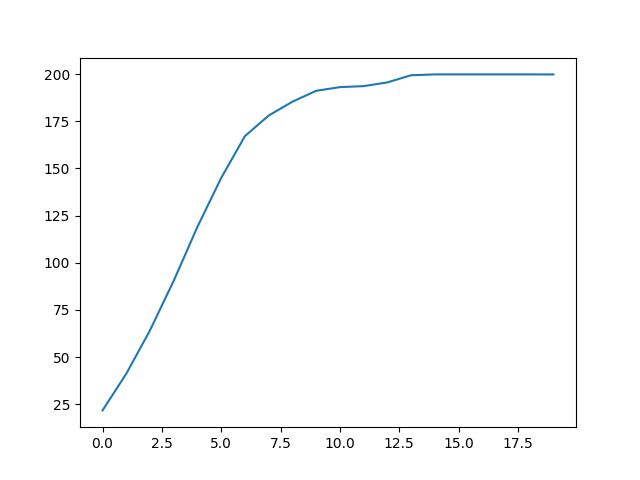

In [71]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [72]:
! pip install tensorboard

In [73]:
! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [76]:
! pip install pyyaml # install package to read yamls, import with yaml

In [79]:
import yaml
import urllib

In [87]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-a3c.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# This gets to ~19-20 reward in ~30 minutes / 4m steps on a m4.10xl instance\n# TODO(rliaw): this has regressed in performance\npong-a3c:\n    env: PongDeterministic-v4\n    run: A3C\n    config:\n        num_workers: 16\n        sample_batch_size: 20\n        use_pytorch: false\n        vf_loss_coeff: 0.5\n        entropy_coeff: 0.01\n        gamma: 0.99\n        grad_clip: 40.0\n        lambda: 1.0\n        lr: 0.0001\n        observation_filter: NoFilter\n        preprocessor_pref: rllib\n        model:\n            use_lstm: true\n            conv_activation: elu\n            dim: 42\n            grayscale: true\n            zero_mean: false\n            # Reduced channel depth and kernel size from default\n            conv_filters: [\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n            ]\n'


In [91]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 16, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}}}


In [102]:
tune_config_example["pong-a3c"]["config"]["num_workers"]=2
tune_config_example["pong-a3c"]["stop"] = {"training_iteration": 10}
print(tune_config_example)

{'pong-a3c': {'run': 'A3C', 'config': {'num_workers': 2, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}, 'env': 'PongDeterministic-v4'}, 'stop': {'training_iteration': 10}}}


In [103]:
ray.tune.run_experiments(tune_config_example)

Trial name,status,loc
A3C_PongDeterministic-v4_4a3c1462,RUNNING,


2020-02-19 07:35:22,952	WARNING worker.py:1063 -- WARNING: 10 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2020-02-19 07:35:22,953	WARNING worker.py:1063 -- WARNING: 11 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-30
  done: false
  episode_len_mean: 933.0
  episode_reward_max: -19.0
  episode_reward_mean: -19.0
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.999
    dispatch_time_ms: 6.055
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 6.20143985748291
      model: {}
      policy_entropy: 35.828086853027344
      policy_loss: 4.84628963470459
      var_gnorm: 25.89760398864746
      vf_explained_var: -0.14878058433532715
      vf_loss: 0.20017409324645996
    num_steps_sampled: 2000
    num_steps_trained: 2000
    wait_time_ms: 28.359
  iterations_since_restore: 1
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.48333333333333
    ram_util_percent: 72.73333333333333
  pid: 224

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,1,7.68848,2000,-19


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-38
  done: false
  episode_len_mean: 923.8
  episode_reward_max: -18.0
  episode_reward_mean: -20.0
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 5
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.702
    dispatch_time_ms: 6.428
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 8.23530101776123
      model: {}
      policy_entropy: 35.81895446777344
      policy_loss: -7.796582221984863
      var_gnorm: 25.91107177734375
      vf_explained_var: -0.03810453414916992
      vf_loss: 2.049349546432495
    num_steps_sampled: 6000
    num_steps_trained: 6000
    wait_time_ms: 29.956
  iterations_since_restore: 2
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 61.36363636363635
    ram_util_percent: 77.70000000000002
  pid: 2242

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,2,15.3946,6000,-20


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-46
  done: false
  episode_len_mean: 961.3
  episode_reward_max: -18.0
  episode_reward_mean: -20.3
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 10
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.92
    dispatch_time_ms: 5.979
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 25.66436004638672
      model: {}
      policy_entropy: 35.73349380493164
      policy_loss: -15.589995384216309
      var_gnorm: 25.9265079498291
      vf_explained_var: 0.009191632270812988
      vf_loss: 3.177231788635254
    num_steps_sampled: 10000
    num_steps_trained: 10000
    wait_time_ms: 29.865
  iterations_since_restore: 3
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 61.17272727272728
    ram_util_percent: 81.27272727272727
  pid: 2

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,3,22.9931,10000,-20.3


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-53
  done: false
  episode_len_mean: 925.1428571428571
  episode_reward_max: -18.0
  episode_reward_mean: -20.428571428571427
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 14
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.613
    dispatch_time_ms: 6.634
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 10.969645500183105
      model: {}
      policy_entropy: 35.18730163574219
      policy_loss: -5.459041118621826
      var_gnorm: 25.94123077392578
      vf_explained_var: -0.00879526138305664
      vf_loss: 1.4715474843978882
    num_steps_sampled: 14000
    num_steps_trained: 14000
    wait_time_ms: 27.919
  iterations_since_restore: 4
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.02
    ram_util_percent: 84.48
  p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,4,30.5197,14000,-20.4286


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-01
  done: false
  episode_len_mean: 879.6
  episode_reward_max: -18.0
  episode_reward_mean: -20.6
  episode_reward_min: -21.0
  episodes_this_iter: 6
  episodes_total: 20
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.874
    dispatch_time_ms: 5.737
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 6.833588123321533
      model: {}
      policy_entropy: 35.36431121826172
      policy_loss: -1.3010973930358887
      var_gnorm: 25.95338249206543
      vf_explained_var: 0.010339975357055664
      vf_loss: 1.2181718349456787
    num_steps_sampled: 18000
    num_steps_trained: 18000
    wait_time_ms: 28.391
  iterations_since_restore: 5
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.93636363636363
    ram_util_percent: 87.5909090909091
  pid:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,5,37.9132,18000,-20.6


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-08
  done: false
  episode_len_mean: 866.5
  episode_reward_max: -18.0
  episode_reward_mean: -20.666666666666668
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 24
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.551
    dispatch_time_ms: 5.731
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 27.192237854003906
      model: {}
      policy_entropy: 34.851470947265625
      policy_loss: -17.285873413085938
      var_gnorm: 25.980113983154297
      vf_explained_var: 0.0008727908134460449
      vf_loss: 3.459970474243164
    num_steps_sampled: 22000
    num_steps_trained: 22000
    wait_time_ms: 29.62
  iterations_since_restore: 6
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.48181818181818
    ram_util_percent: 90.7454

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,6,45.3685,22000,-20.6667


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-15
  done: false
  episode_len_mean: 852.6666666666666
  episode_reward_max: -18.0
  episode_reward_mean: -20.733333333333334
  episode_reward_min: -21.0
  episodes_this_iter: 6
  episodes_total: 30
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 2.217
    dispatch_time_ms: 5.555
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 34.026512145996094
      model: {}
      policy_entropy: 35.20148849487305
      policy_loss: -24.611927032470703
      var_gnorm: 26.00190544128418
      vf_explained_var: -0.06230795383453369
      vf_loss: 5.48494291305542
    num_steps_sampled: 26000
    num_steps_trained: 26000
    wait_time_ms: 29.047
  iterations_since_restore: 7
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.980000000000004
    ram_util_percen

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,7,52.7484,26000,-20.7333


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-23
  done: false
  episode_len_mean: 865.1176470588235
  episode_reward_max: -18.0
  episode_reward_mean: -20.705882352941178
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 34
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.56
    dispatch_time_ms: 5.832
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 3.5779833793640137
      model: {}
      policy_entropy: 35.12071228027344
      policy_loss: -0.23137566447257996
      var_gnorm: 26.018766403198242
      vf_explained_var: -0.0048400163650512695
      vf_loss: 1.1878029108047485
    num_steps_sampled: 30000
    num_steps_trained: 30000
    wait_time_ms: 29.938
  iterations_since_restore: 8
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.27272727272726
    ram_util_pe

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,8,60.0754,30000,-20.7059


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-30
  done: false
  episode_len_mean: 879.2894736842105
  episode_reward_max: -18.0
  episode_reward_mean: -20.657894736842106
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 38
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.737
    dispatch_time_ms: 5.849
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 33.95669174194336
      model: {}
      policy_entropy: 35.040000915527344
      policy_loss: -25.83295440673828
      var_gnorm: 26.031211853027344
      vf_explained_var: 0.0006200671195983887
      vf_loss: 5.436253547668457
    num_steps_sampled: 34000
    num_steps_trained: 34000
    wait_time_ms: 31.685
  iterations_since_restore: 9
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.730000000000004
    ram_util_perc

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,9,67.4694,34000,-20.6579


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-38
  done: true
  episode_len_mean: 880.047619047619
  episode_reward_max: -18.0
  episode_reward_mean: -20.69047619047619
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 42
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.75
    dispatch_time_ms: 6.067
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 11.634791374206543
      model: {}
      policy_entropy: 34.87805938720703
      policy_loss: 7.163380146026611
      var_gnorm: 26.045175552368164
      vf_explained_var: -0.0026030540466308594
      vf_loss: 0.5883638858795166
    num_steps_sampled: 38000
    num_steps_trained: 38000
    wait_time_ms: 28.973
  iterations_since_restore: 10
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.0090909090909
    ram_util_percent:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,TERMINATED,,10,74.8096,38000,-20.6905


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,TERMINATED,,10,74.8096,38000,-20.6905


[A3C_PongDeterministic-v4_4a3c1462]

# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [108]:
ray.is_initialized()

True

In [109]:
ray.nodes()

[{'NodeID': 'eb9b742310e4451ea650be653b435b72e90dc48a',
  'Alive': True,
  'NodeManagerAddress': '192.168.1.170',
  'NodeManagerHostname': 'GDA-Oryx-Pro',
  'NodeManagerPort': 41117,
  'ObjectManagerPort': 38509,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-19_05-47-35_354974_19949/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-19_05-47-35_354974_19949/sockets/raylet',
  'Resources': {'node:192.168.1.170': 1.0,
   'CPU': 3.0,
   'memory': 100.0,
   'GPU': 1.0,
   'object_store_memory': 34.0},
  'alive': True}]

In [110]:
ray.cluster_resources()

{'node:192.168.1.170': 1.0,
 'CPU': 3.0,
 'memory': 100.0,
 'GPU': 1.0,
 'object_store_memory': 34.0}

In [112]:
ray.shutdown()

In [113]:
ray.is_initialized()

False